# Emoji Prediction using Transfer Learning

Understanding the sentiment of the sentence and then predicting an Emoji for it.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import emoji

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

from matplotlib import pyplot as plt
import seaborn as sns

print ("Imports ready!")

Imports ready!


## Goal of the project

The task is to build an Emojifier by using word vector representations. The model will take an input sentence and find the most appropriate emoji to be used with this sentence - from an assortment of 5 emoji's at its disposal.

- 😁
- 😓
- 🖤
- 🍴
- ⚾

## Loading the dataset

In [2]:
train = pd.read_csv ('dataset/train_emoji.csv', usecols = [0, 1], header = None)
test = pd.read_csv ('dataset/test_emoji.csv', usecols = [0, 1], header = None)

print (f'Training data shape = {train.shape}, Validation data shape = {test.shape}')

train.head (3)

Training data shape = (132, 2), Validation data shape = (56, 2)


,0,1
0,never talk to me again,3
1,I am proud of your achievements,2
2,It is the worst day in my life,3


In [3]:
train[1].value_counts()

2    38
3    36
0    22
1    19
4    17
Name: 1, dtype: int64

In [4]:
test.head (3)

,0,1
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2


## Data Preparation

In [5]:
'''  
    Mapping label to a emoji
'''

emoji_dictionary = {"0": "\u2764\uFE0F",    # 🖤
                    "1": ":baseball:", # ⚾
                    "2": ":beaming_face_with_smiling_eyes:", # 😁
                    "3": ":downcast_face_with_sweat:", # 😓
                    "4": ":fork_and_knife:", # 🍴
                   }

In [6]:
'''
    Getting x_train, y_train from train.csv
    x_test, y_test from test.csv
'''

x_train = train.values[:, 0]
y_train = to_categorical (train.values[:, 1])

x_test = test.values[:, 0]
y_test = to_categorical (test.values[:, 1])

In [7]:
maxLen = 0 # Len of longest sentence (by number of words)

for sent in x_train:
    maxLen = max (maxLen, len (sent.split (' ')))

for sent in x_test:
    maxLen = max (maxLen, len (sent.split (' ')))
    
print (f"Length of longest sentence (by number of words) is : {maxLen}")

Length of longest sentence (by number of words) is : 10


In [8]:
'''
    Frst 10 training points
'''

for i, sent in enumerate (x_train):
    if i == 10:
        break
    label = str (np.argmax (y_train[i]))
    print (f"Sentence : {sent} , Emoji : {emoji.emojize (emoji_dictionary[label])}")

Sentence : never talk to me again , Emoji : 😓
Sentence : I am proud of your achievements , Emoji : 😁
Sentence : It is the worst day in my life , Emoji : 😓
Sentence : Miss you so much , Emoji : ❤️
Sentence : food is life , Emoji : 🍴
Sentence : I love you mum , Emoji : ❤️
Sentence : Stop saying bullshit , Emoji : 😓
Sentence : congratulations on your acceptance , Emoji : 😁
Sentence : The assignment is too long  , Emoji : 😓
Sentence : I want to go play , Emoji : ⚾


## Creating word embeddings for the words that are present in the dataset

I'll be using word vector representations of the words in the sentence so I need word vector representations of the words in the sentences. I'll use the Glove vectors for this representation.                     
                
Based on few iterations 100 d vectors seem to work best for this case.

In [9]:
'''
embeddings dictionary:
    key = word
    value = embedding vector [100 dimension vector]
'''

embeddings = {}
with open ('glove.6B.100d.txt', encoding = 'utf-8') as f:
    for line in f:
        values = line.split () # splits the word and coeff
        word = values[0] # word
        coeffs = np.asarray (values[1 : ], dtype = 'float32') # makes a word vector of len 50 for each word
        embeddings[word] = coeffs

In [10]:
def getOutputEmbeddings(X):
    
    embedding_matrix_output = np.zeros ((X.shape[0], 10, 100)) # X.shape (num_of_sentences, max_len, embedding_dim)
    for ix in range (X.shape[0]): # go to every sentence
        X[ix] = X[ix].split () # get a list of words of the sentence
        for jx in range (len(X[ix])): # go to every word
            embedding_matrix_output[ix][jx] = embeddings[X[ix][jx].lower ()]
            
    return embedding_matrix_output

In [11]:
emb_x_train = getOutputEmbeddings(x_train) # getting embeddings for train data
emb_x_test = getOutputEmbeddings(x_test) # getting embeddings for test data

emb_x_train.shape, emb_x_test.shape

((132, 10, 100), (56, 10, 100))

## Model

In [12]:
model = Sequential()
model.add (LSTM (128, input_shape = (10, 100),return_sequences=True)) # to create a stacked LSTM model
model.add (Dropout (0.5)) # regularisation
model.add (LSTM (128, input_shape = (10, 100))) # stacking LSTM layer
model.add (Dropout (0.5))
model.add (Dense (5))
model.add (Activation ('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           117248    
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 249,477
Trainable params: 249,477
Non-trainable params: 0
__________________________________________________

In [13]:
'''Callbacks'''

reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.3, patience = 3, min_lr = 0.0001, verbose = 1)
checkpoint = ModelCheckpoint ("best_model.h5", monitor = 'val_acc', verbose = True, save_best_only = True)

callbacks = [reduce_lr, checkpoint]

In [14]:
model.compile (optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
hist = model.fit (emb_x_train, y_train, epochs = 25, batch_size = 16, shuffle = True, validation_split = 0.3, callbacks = callbacks)

Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 1.6126 - acc: 0.2543
Epoch 00001: val_acc improved from -inf to 0.35000, saving model to best_model.h5
6/6 [==============================] - 7s 1s/step - loss: 1.6090 - acc: 0.2568 - val_loss: 1.5709 - val_acc: 0.3500
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 1.5456 - acc: 0.3066
Epoch 00002: val_acc did not improve from 0.35000
6/6 [==============================] - 0s 47ms/step - loss: 1.5369 - acc: 0.3156 - val_loss: 1.5034 - val_acc: 0.3500
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 1.4059 - acc: 0.4240
Epoch 00003: val_acc improved from 0.35000 to 0.40000, saving model to best_model.h5
6/6 [==============================] - 0s 50ms/step - loss: 1.4004 - acc: 0.4256 - val_loss: 1.4751 - val_acc: 0.4000
Epoch 4/25
6/6 [==============================] - ETA: 0s - loss: 1.2822 - acc: 0.5364
Epoch 00004: val_acc improved from 0.40000 to 0.62500, saving model to best_model.h

## Model Accuracy

In [15]:
model.load_weights ('best_model.h5')
model.evaluate (emb_x_test, y_test)

2/2 [==============================] - 0s 21ms/step - loss: 1.1657 - acc: 0.5893


[1.1656949520111084, 0.5892857313156128]

## Checking the predictions

In [16]:
pred = model.predict_classes(emb_x_test)

In [17]:
print("Sentence      : Actual       Prediction")
for i in range(10):
    print(' '.join(x_test[i]), end = " : ")
    print(emoji.emojize(emoji_dictionary[str(np.argmax(y_test[i]))]), end = " \t\t")
    print(emoji.emojize(emoji_dictionary[str(pred[i])]))

Sentence      : Actual       Prediction
I want to eat : 🍴 		🍴
he did not answer : 😓 		😓
he got a raise : 😁 		😓
she got me a present : ❤️ 		😓
ha ha ha it was so funny : 😁 		😁
he is a good friend : ❤️ 		😓
I am upset : ❤️ 		😓
We had such a lovely dinner tonight : ❤️ 		😓
where is the food : 🍴 		🍴
Stop making this joke ha ha ha : 😁 		😁


I am upset : ❤️ 		😓                 
We had such a lovely dinner tonight : ❤️ 		😁            
    
for these sentences our predictions were also good.

In [18]:

'''
    Confusion Matrix
'''

Y_test = [np.argmax (i) for i in y_test] 

cm = confusion_matrix(Y_test, pred)

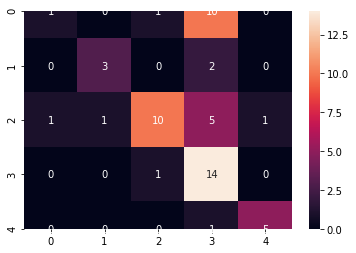

In [19]:
sns.heatmap(cm, annot = True)
plt.show ()

## Tasks for future

- Get more data
- Try different model architectures

________